In [1]:
import numpy as np
from scipy.interpolate import interp1d, RegularGridInterpolator
import matplotlib.pyplot as plt
%matplotlib inline

import os

# set displayed dpi to 300
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

In [ ]:
plot       = [  True,   True,   True,  False,   True,      True]
#plot       = [ False,  False,  False,  False,   True,      True]
names      = ['H2O1', 'H2O1', 'C1H4', 'C1H4', 'C1O2', 'N2+C1O2']
saturation = [   0.0,    1.0,    1.0,    1.0,    1.0,       1.0]
max_mr     = [   1.0,    1.0,    1.0,    0.1,    1.0,       1.0]

labels = []

for i in range(len(names)):

    labels.append(names[i].replace('1', ''))
    if '+' not in labels[i]:
        labels[i] = 'H2+' + labels[i]

    names[i] = names[i] + f'_sat={saturation[i]:.0e}'

    if saturation[i] != 1.0:
        labels[i] = labels[i] + f'\n(sat={saturation[i]:.0e})'

    if saturation[i] == 0.0:
        labels[i] = labels[i][:2]
    
    if max_mr[i] != 1.0:
        names[i] = names[i] + f'_maxMR={max_mr[i]:.0e}'
        labels[i] = labels[i] + f'\n(maxMR={max_mr[i]:.0e})'

T_int = np.arange(50, 251, 25)
P_boa = np.array([1, 10])

tp_dir = f'../output/h2+sat/'

# habitability params
T_freeze = 273.15 # K
T_boil = np.array([100, 180, 310]) # deg C for P = [1, 10, 100] bar
T_boil = T_boil + T_freeze # K
P_boil = np.array([1, 10, 100]) # bar

In [3]:
T_surf = np.zeros((len(names), len(P_boa), len(T_int)))

filenames = np.zeros_like(T_surf, dtype=object)

for i in range(len(names)):
    for i_p, P in enumerate(P_boa):
        for i_t, T in enumerate(T_int):
            for j in np.arange(1): # changed to 1 to view only the first rep !!!
                filename = names[i] + f'_Tint={T}K_P0={P}bar_A=01_rep={j}'
                
                if os.path.isfile(tp_dir + filename + f'/{filename}_tp.dat'):
                    tp = np.loadtxt(tp_dir + filename + f'/{filename}_tp.dat', skiprows=2, usecols=(1,2))
                elif os.path.isfile(tp_dir + filename + f'/{filename}_tp_coupling_30001.dat'):
                    tp = np.loadtxt(tp_dir + filename + f'/{filename}_tp_coupling_30001.dat', skiprows=1, usecols=(1,0))
                    #filename = filename + '_x'
                elif os.path.isfile(tp_dir + filename + f'/{filename}_tp_coupling_30000.dat'):
                    tp = np.loadtxt(tp_dir + filename + f'/{filename}_tp_coupling_30000.dat', skiprows=1, usecols=(1,0))
                    #filename = filename + '_y'
                else:
                    if j == 0:
                        tp[0,0] = np.nan
                        print(f'File {filename} not found')
                    if filename[-2:] == '_x' or filename[-2:] == '_y':
                        print(filename + ' not converged')
                    break
            
            T_surf[i, i_p, i_t] = tp[0,0]

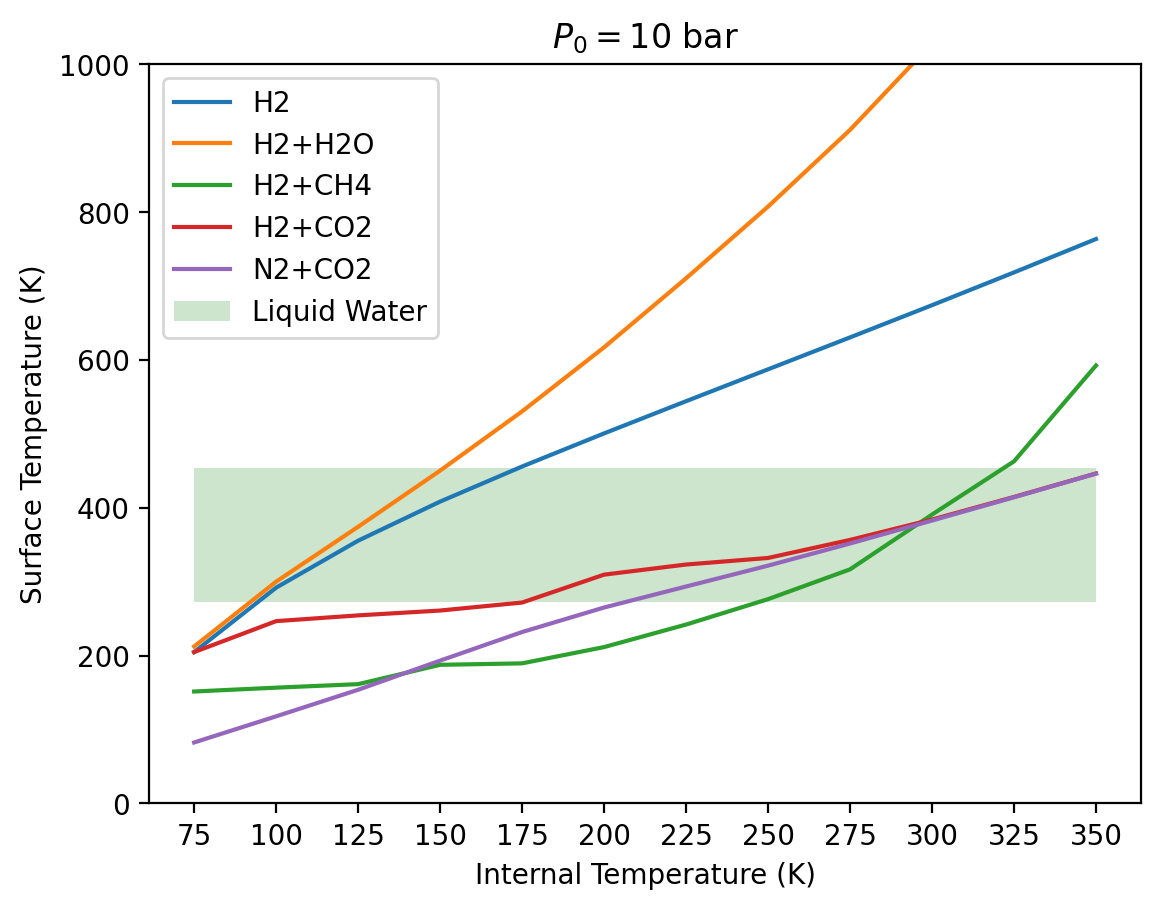

In [4]:
i_p = 1   # 0 = 1 bar, 1 = 10 bar

for i in range(len(names)):
    if not plot[i]:
        continue
    plt.plot(T_int, T_surf[i, i_p, :], label=labels[i])

plt.fill([T_int[0], T_int[0], T_int[-1], T_int[-1]], [T_boil[i_p], T_freeze, T_freeze, T_boil[i_p]], 'green', alpha=0.2, label='Liquid Water')

plt.ylim(0, 1e3)

plt.title(r'$P_0 =$' + f'{P_boa[i_p]} bar')
plt.xticks(T_int)
plt.xlabel('Internal Temperature (K)')
plt.ylabel('Surface Temperature (K)')
plt.legend(loc='upper left')

In [5]:
# connect Tsurf to time evolution

# read in T_eff data from data/T_eff.dat (format: index, time, T_eff)
T_eff = np.loadtxt('data/T_eff.dat')
print(T_eff.shape)

n_time = int(1000/10 + 1)

T_eff = T_eff.reshape((-1,n_time,3))
print(T_eff.shape)
print(T_eff[2,:,0].astype(int))

(701445, 3)
(6945, 101, 3)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Time t = 300.95966959047416
> inf K: 0 out of 6945


Text(0.5, 1.0, 'T_eff at t=301 Myr')

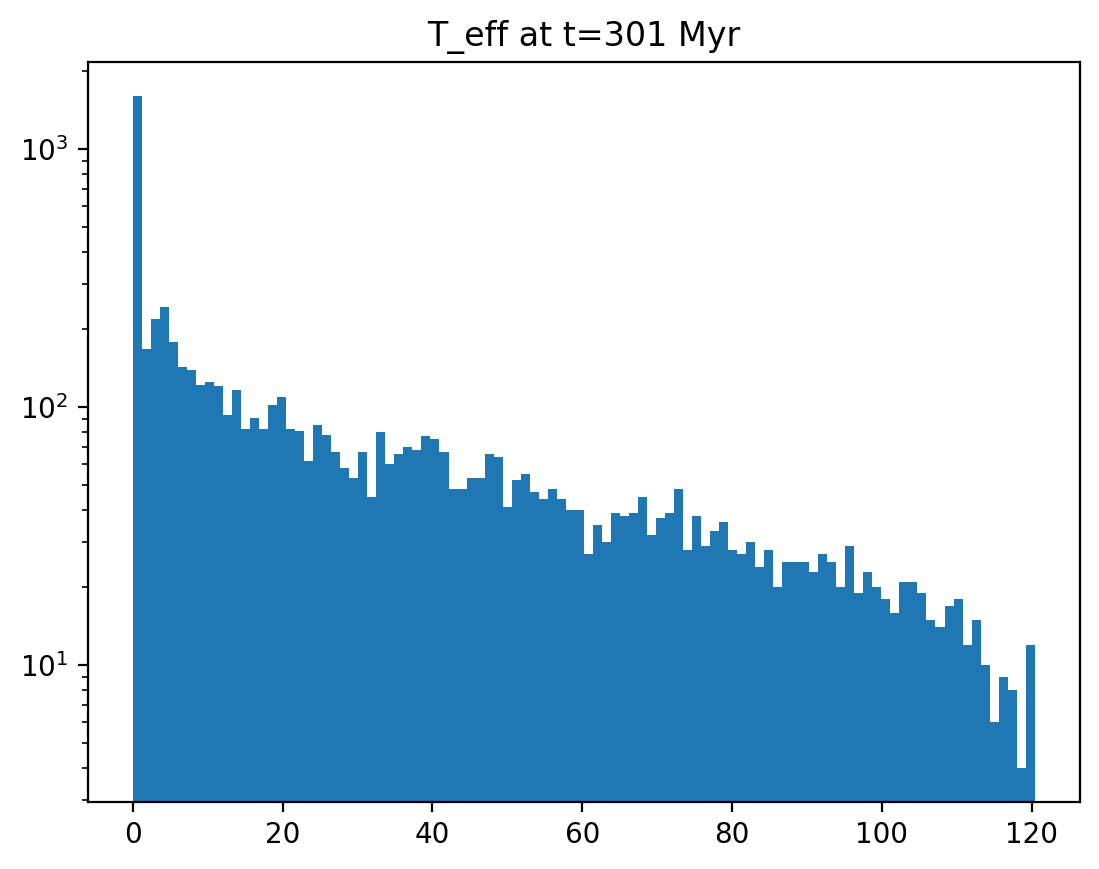

In [6]:
time = 300 # Myr
i_time = np.argmin(np.abs(T_eff[0,:,1] - time))
print('Time t =', T_eff[0,i_time,1])

plot_T_eff = T_eff[:,i_time,2]

T_max = np.inf
T_eff_mask = plot_T_eff < T_max
print(f'> {T_max} K:', np.sum(~T_eff_mask), 'out of', len(plot_T_eff))
plot_T_eff = plot_T_eff[T_eff_mask]


plt.hist(plot_T_eff, bins=100, log=True)
plt.title(f'T_eff at t={T_eff[0,i_time,1]:.0f} Myr')

In [7]:
# calculate time spent in the habitable zone

t_minmax = np.zeros((len(names), len(P_boa), T_eff.shape[0], 2))

for i in range(len(names)):
    for i_p, P in enumerate(P_boa):
        habitable = np.zeros(T_eff.shape[0], dtype=bool)
        for i_t in range(n_time):
            T_eff_i = T_eff[:, i_t, 2]
            T_surf_i = np.interp(T_eff_i, T_int, T_surf[i, i_p, :])

            mask = np.logical_and(T_surf_i >= T_freeze, T_surf_i <= T_boil[i_p])
            if np.any(mask):
                mask = np.logical_and(~habitable, mask)
                t_minmax[i, i_p, mask, 0] = T_eff[mask, i_t, 1]
                habitable[mask] = True
            
            mask = np.logical_and(habitable, ~mask)
            if np.any(mask):
                t_minmax[i, i_p, mask, 1] = T_eff[mask, i_t, 1]
                habitable[mask] = False


print(t_minmax.min(), t_minmax.max())

time_habitable = t_minmax[:, :, :, 1] - t_minmax[:, :, :, 0]
print(time_habitable[time_habitable!=0.0].min(), time_habitable.max())
print(time_habitable.shape)


0.0 756.6654768676003
0.09659129955659385 66.64122044021417
(6, 2, 6945)


Habitability for an H2+H2O atmosphere
for P0 = 1 bar: 1325 out of 6945 reach the HZ
for P0 = 10 bar: 2111 out of 6945 reach the HZ


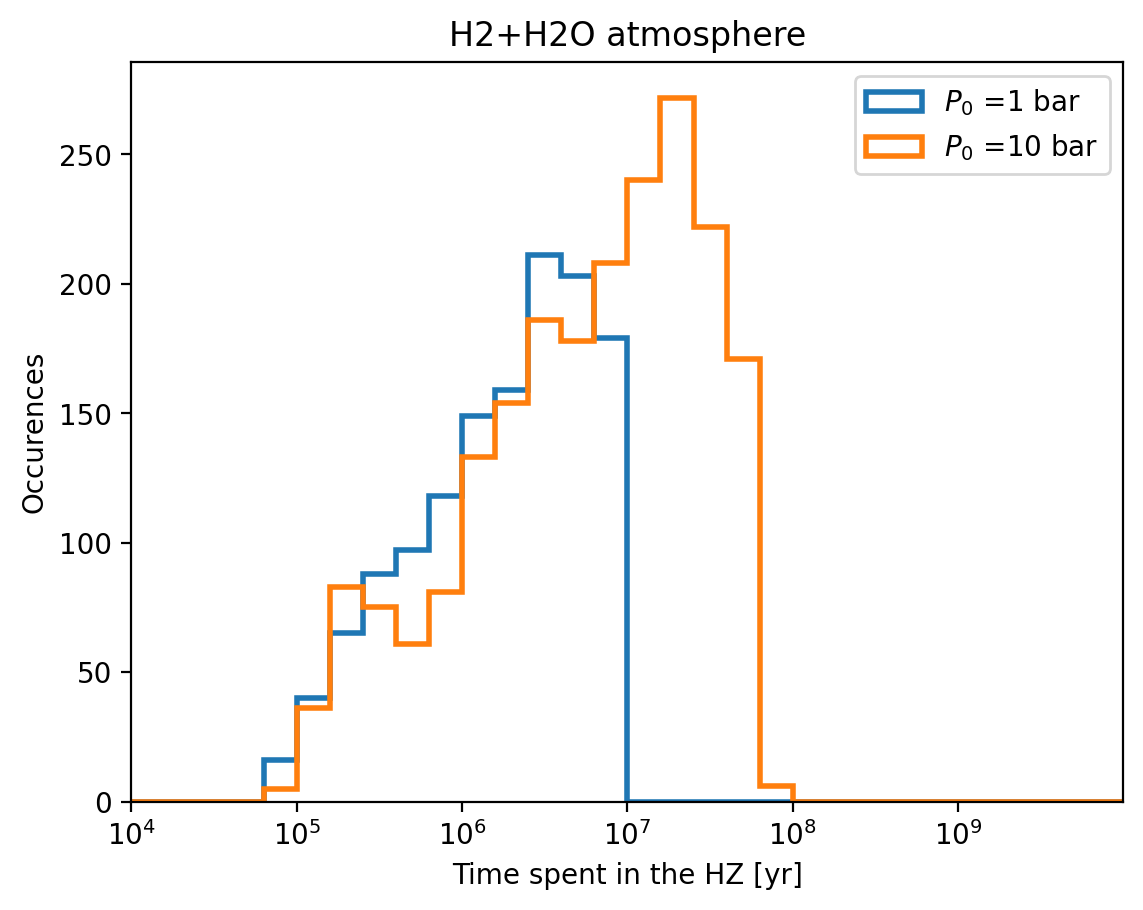

In [8]:
i_name = 1

hist_min = 4 - 6
hist_max = 10 - 6

print(f'Habitability for an {labels[i_name]} atmosphere')
for i_p, P in enumerate(P_boa):
    mask = time_habitable[i_name, i_p, :] > 0
    print(f'for P0 = {P} bar:', np.sum(mask), 'out of', len(mask), 'reach the HZ')
    plt.hist(np.log10(time_habitable[i_name, i_p, mask]), bins=np.linspace(hist_min, hist_max, 31), label=r'$P_0$ =' + f'{P} bar', histtype='step', linewidth=2)

plt.xticks(np.arange(hist_min, hist_max, 1), [r'$10^{i}$'.format(i=i) for i in np.arange(hist_min, hist_max, 1)+6])
plt.xlim(hist_min, hist_max)

plt.title(f'{labels[i_name]} atmosphere')
plt.xlabel('Time spent in the HZ [yr]')
plt.ylabel('Occurences')

plt.legend()

Habitability for P0 = 10 bar
for H2: 1245 out of 6945 or 17.9% reach the HZ
for H2+H2O: 1325 out of 6945 or 19.1% reach the HZ
for H2+CH4: 752 out of 6945 or 10.8% reach the HZ
for H2+CO2: 877 out of 6945 or 12.6% reach the HZ
for N2+CO2: 868 out of 6945 or 12.5% reach the HZ


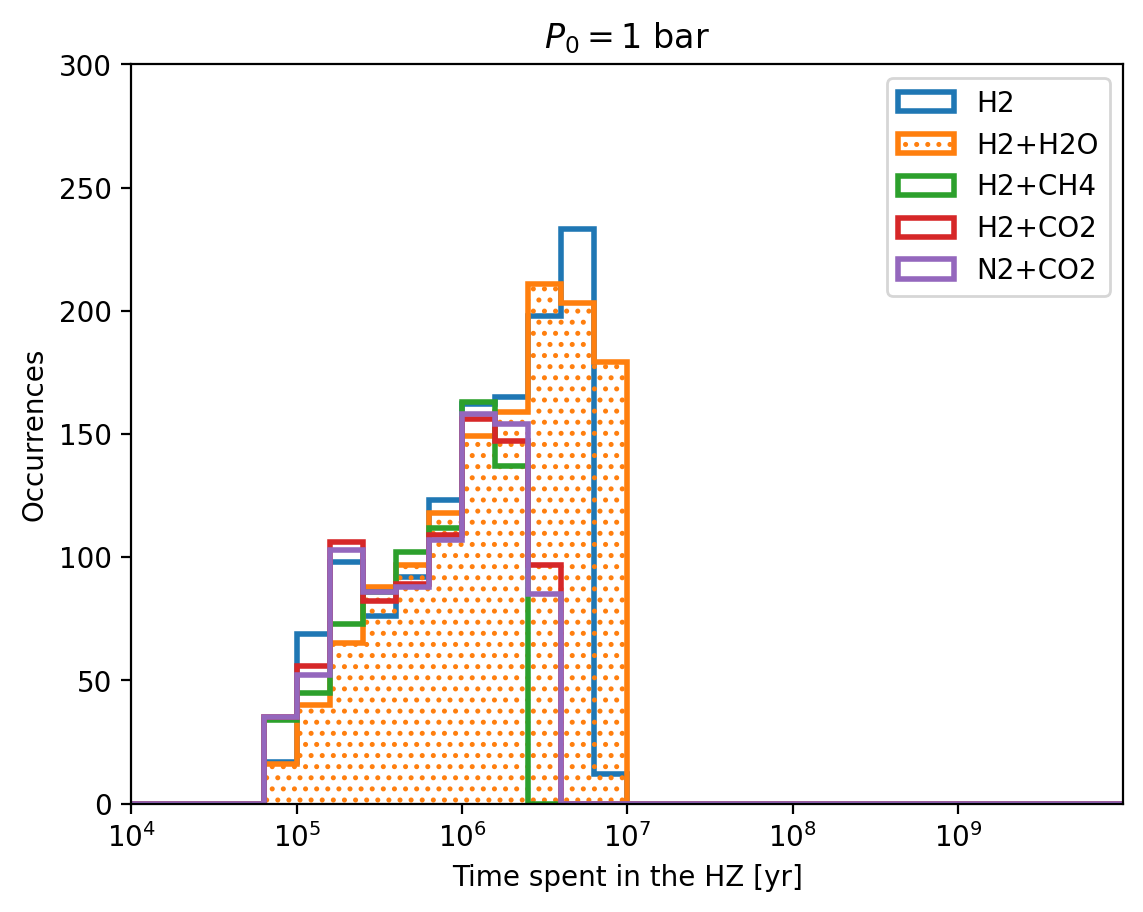

In [26]:
i_p = 0

hist_min = 4 - 6
hist_max = 10 - 6

hatches = ['', '...', '', '', '', '']

print(f'Habitability for P0 = {P} bar')
for i_name in range(len(names)):
    if not plot[i_name]:
        continue
    mask = time_habitable[i_name, i_p, :] > 0
    print(f'for {labels[i_name].replace('\n', ' ')}:', np.sum(mask), 'out of', len(mask), f'or {np.sum(mask)/len(mask)*100:.1f}% reach the HZ')
    plt.hist(np.log10(time_habitable[i_name, i_p, mask]), bins=np.linspace(hist_min,hist_max,31), label=labels[i_name],\
             histtype='step', linewidth=2, hatch=hatches[i_name])

plt.xticks(np.arange(hist_min, hist_max, 1), [r'$10^{i}$'.format(i=i) for i in np.arange(hist_min, hist_max, 1)+6])
plt.xlim(hist_min, hist_max)
plt.ylim(0, 300)

plt.title(r'$P_0 =$' + f'{P_boa[i_p]} bar')
plt.xlabel('Time spent in the HZ [yr]')
plt.ylabel('Occurrences')

plt.legend()